In [47]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)



import numpy as np
import pandas as pd

from IPython.core.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

# configure plotly graph objects
pio.renderers.default = 'iframe'
# pio.renderers.default = 'vscode'

pio.templates["ck_template"] = go.layout.Template(
    layout_colorway = px.colors.sequential.Viridis, 
#     layout_hovermode = 'closest',
#     layout_hoverdistance = -1,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font = dict(family="Calibri Light"),
    layout_title_font = dict(family="Calibri"),
    layout_hoverlabel_font = dict(family="Calibri Light"),
#     plot_bgcolor="white",
)
 
# pio.templates.default = 'seaborn+ck_template+gridon'
pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

In [8]:
train = pd.read_csv('UNSW_NB15_training-set.csv')
test = pd.read_csv('UNSW_NB15_testing-set.csv')
train.shape

(175341, 45)

In [9]:
test.shape

(82332, 45)

In [10]:
unique_chars = train['attack_cat'].unique()

print(unique_chars)

['Normal' 'Backdoor' 'Analysis' 'Fuzzers' 'Shellcode' 'Reconnaissance'
 'Exploits' 'DoS' 'Worms' 'Generic']


In [42]:
CLASS_NORMAL = 'Normal'

class_names = ['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode' ,'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic']

In [12]:
new_columns = list(train.columns)
new_columns[-2] = 'target'
train.columns = new_columns

In [13]:
train.target.value_counts()

target
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

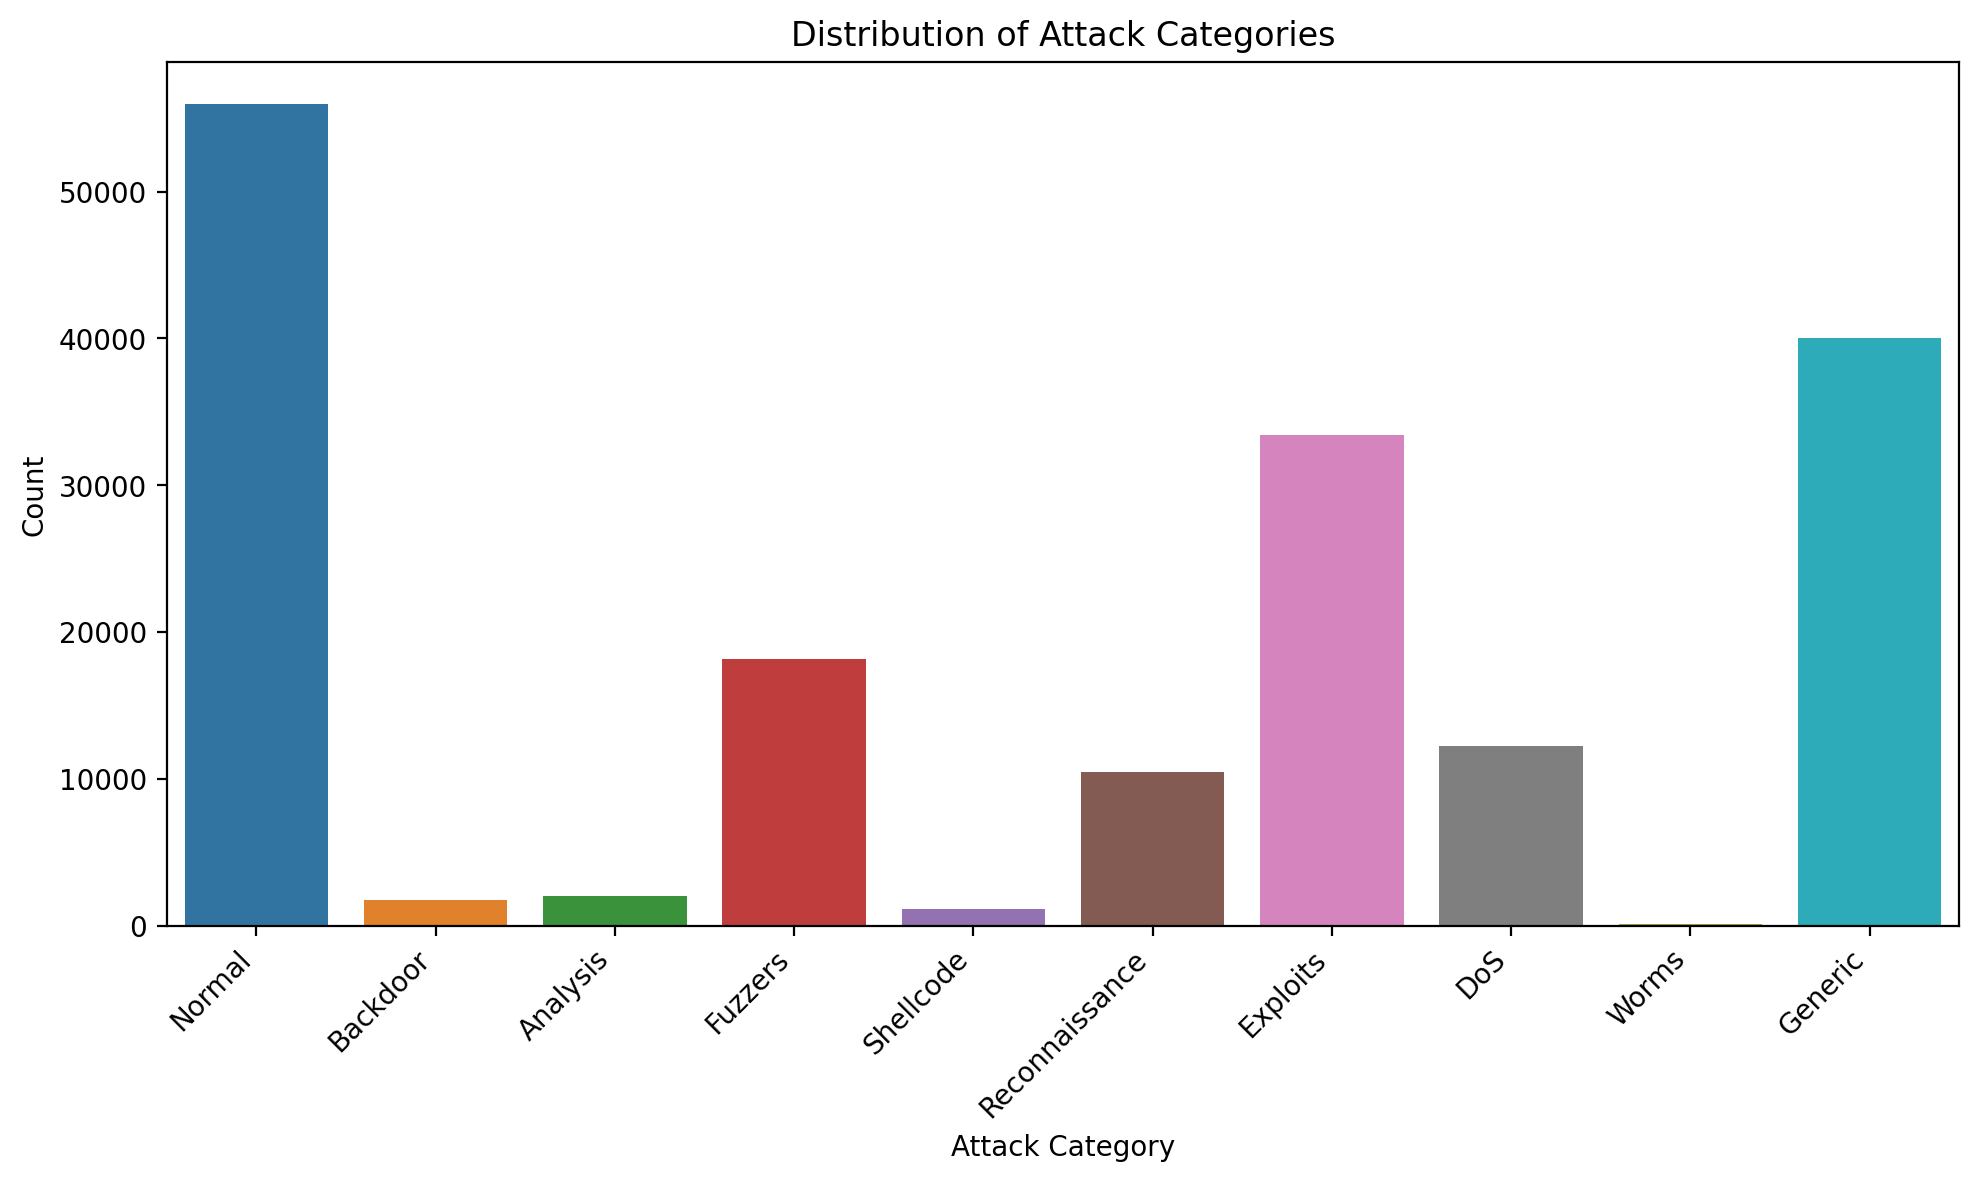

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train, x='target')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.title('Distribution of Attack Categories')

plt.tight_layout()
plt.show()

In [20]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

In [30]:
list_drop = ['target','proto','service','state']

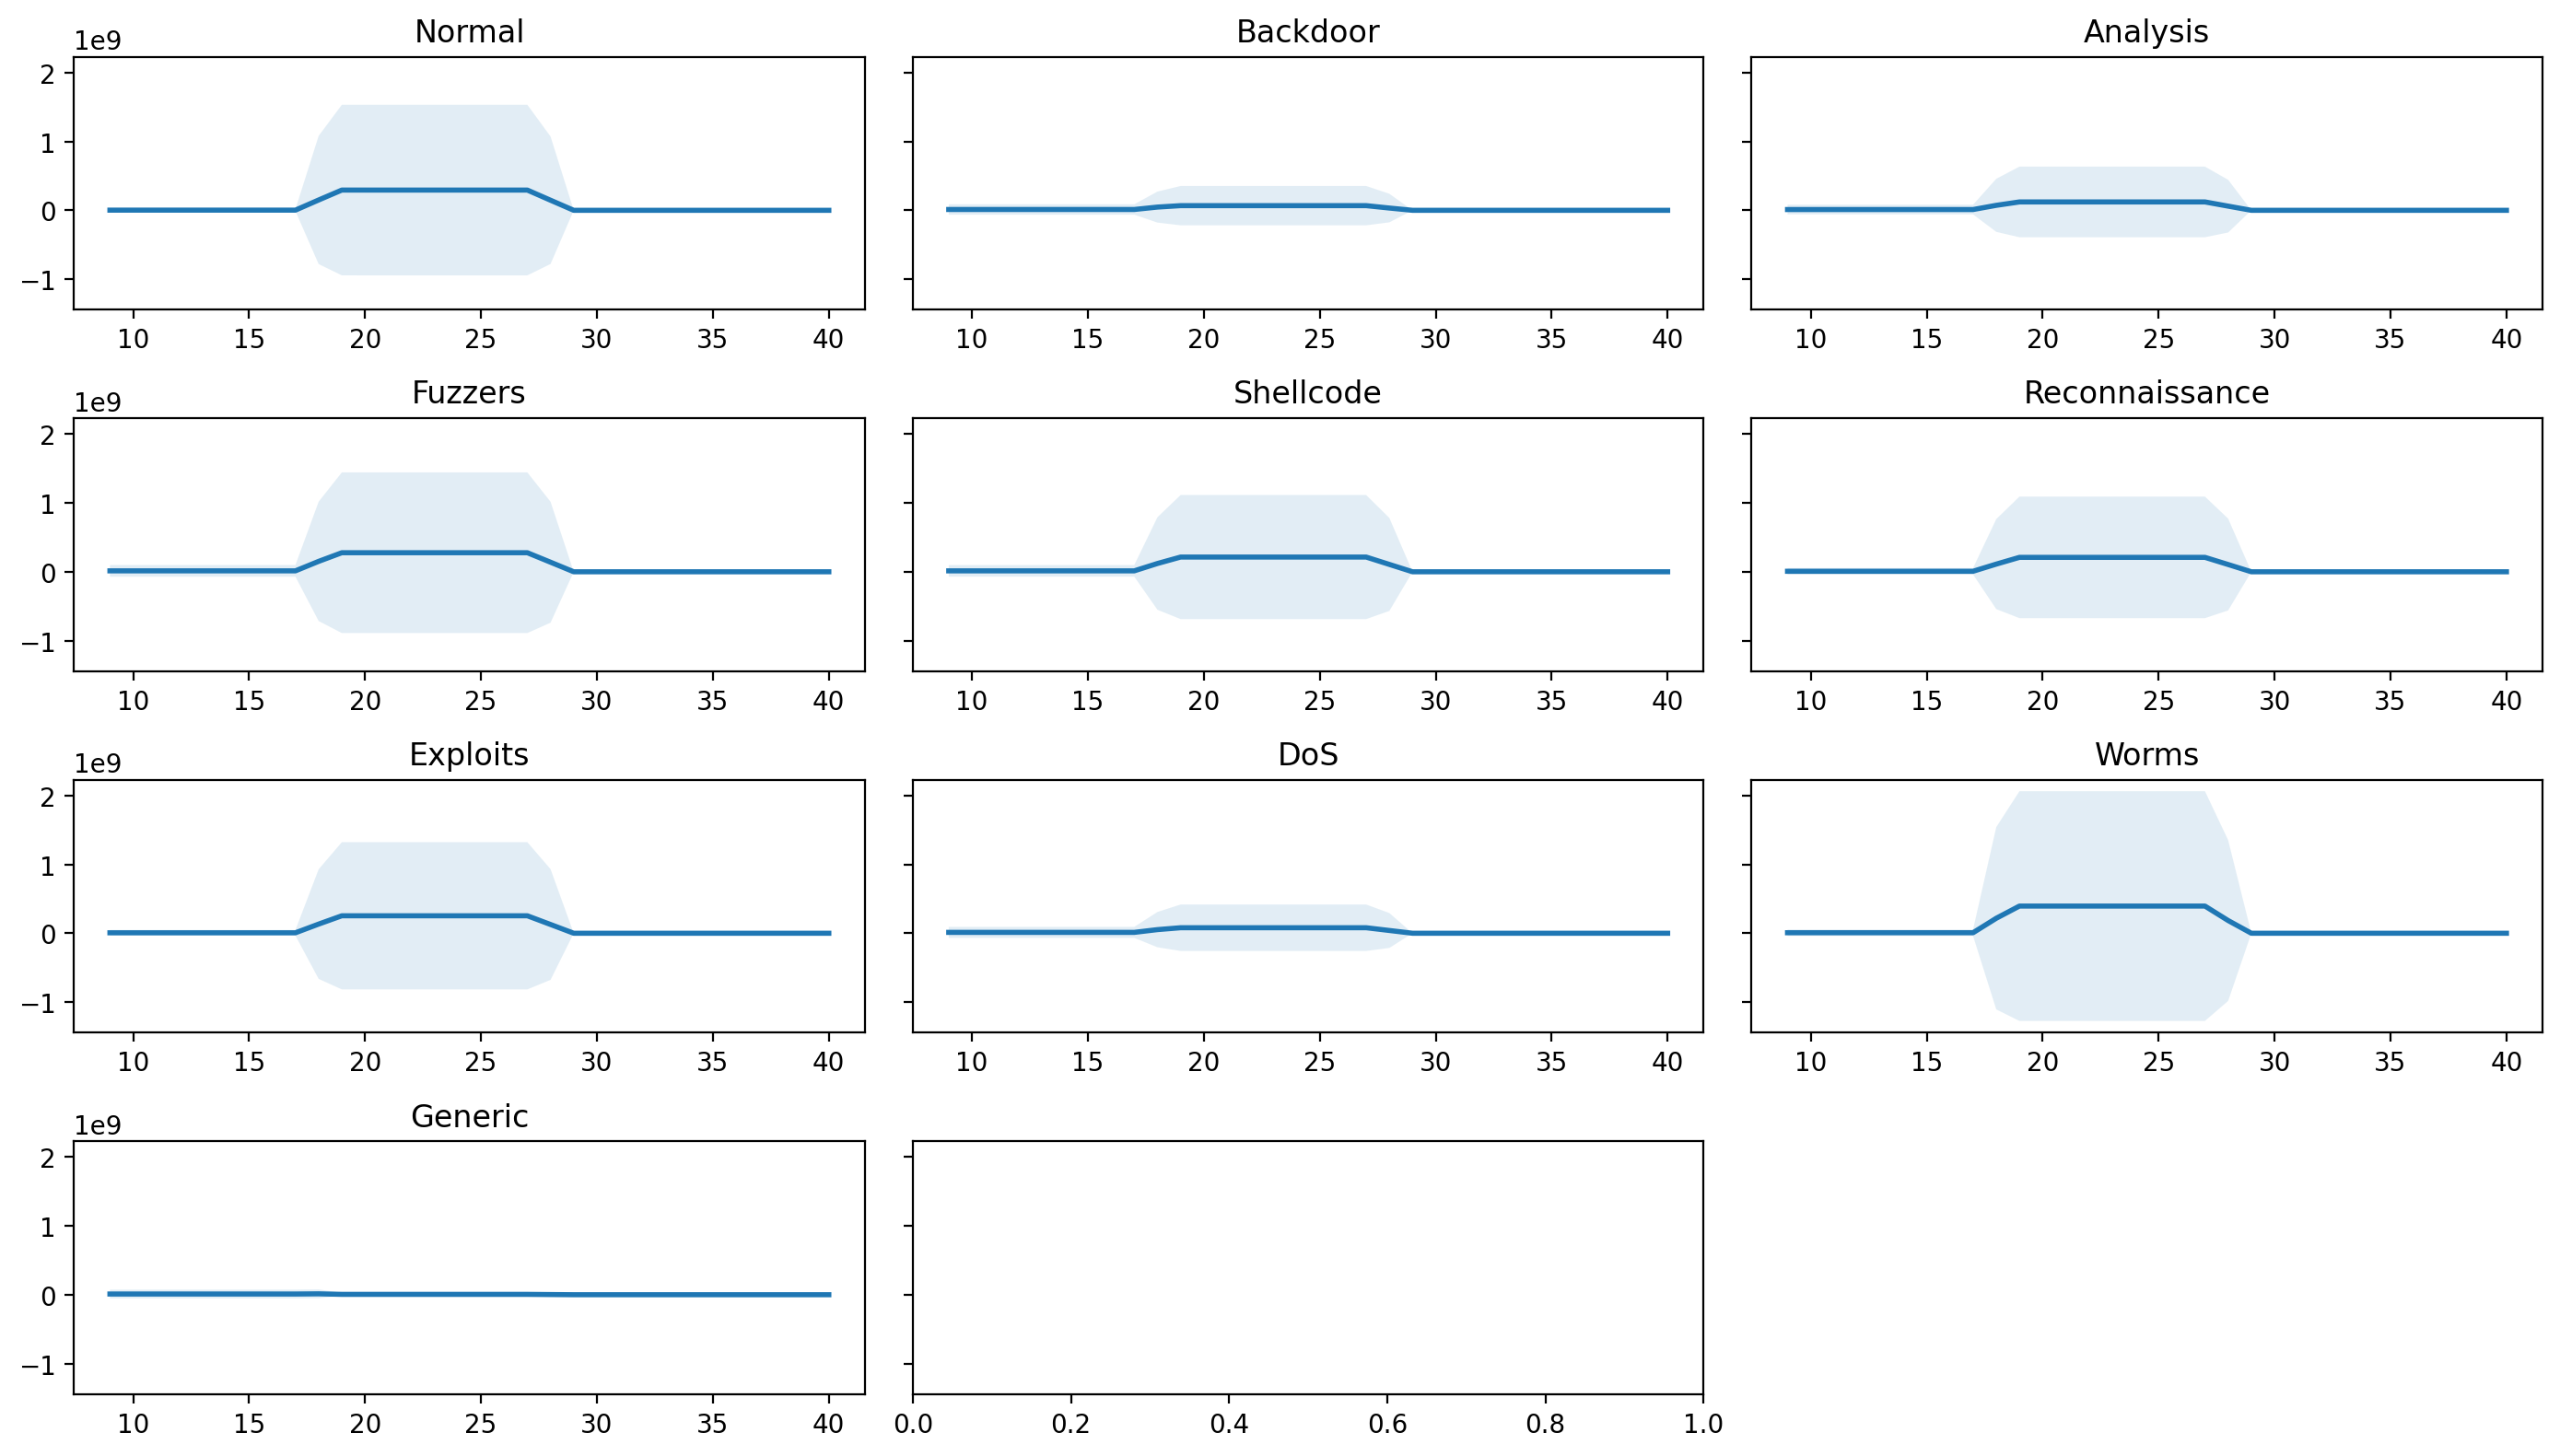

In [39]:
classes = train.target.unique()
fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = train[train.target == cls] \
    .drop(labels=list_drop, axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [55]:
normal_df = train[train.target == str(CLASS_NORMAL)].drop(labels=list_drop, axis=1)
normal_df.shape

(56000, 41)

In [56]:
anomaly_df = train[train.target != str(CLASS_NORMAL)].drop(labels=list_drop, axis=1)
anomaly_df.shape

(119341, 41)

In [57]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [58]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [59]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [60]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [61]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [66]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [67]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [68]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=150
)

Epoch 1: train loss 2967919173.7435813 val loss 2949991953.5001726
Epoch 2: train loss 2967887450.489353 val loss 2949962468.5892544
Epoch 3: train loss 2967860260.044047 val loss 2949938982.881248
Epoch 4: train loss 2967835075.117484 val loss 2949912826.1019936
Epoch 5: train loss 2967810686.3671722 val loss 2949889128.4357996
Epoch 6: train loss 2967787313.8958483 val loss 2949865903.4849863
Epoch 7: train loss 2967764553.061721 val loss 2949843369.7012835
Epoch 8: train loss 2967742538.8613214 val loss 2949823018.6542044
Epoch 9: train loss 2967721756.642881 val loss 2949801592.8447394
Epoch 10: train loss 2967702279.2077336 val loss 2949782948.509772
Epoch 11: train loss 2967682442.0976696 val loss 2949761243.358273
Epoch 12: train loss 2967663139.8308625 val loss 2949744589.5514407
Epoch 13: train loss 2967644212.4708214 val loss 2949725189.4307885
Epoch 14: train loss 2967624936.623238 val loss 2949703816.689002
Epoch 15: train loss 2967604347.0477567 val loss 2949686840.3859572

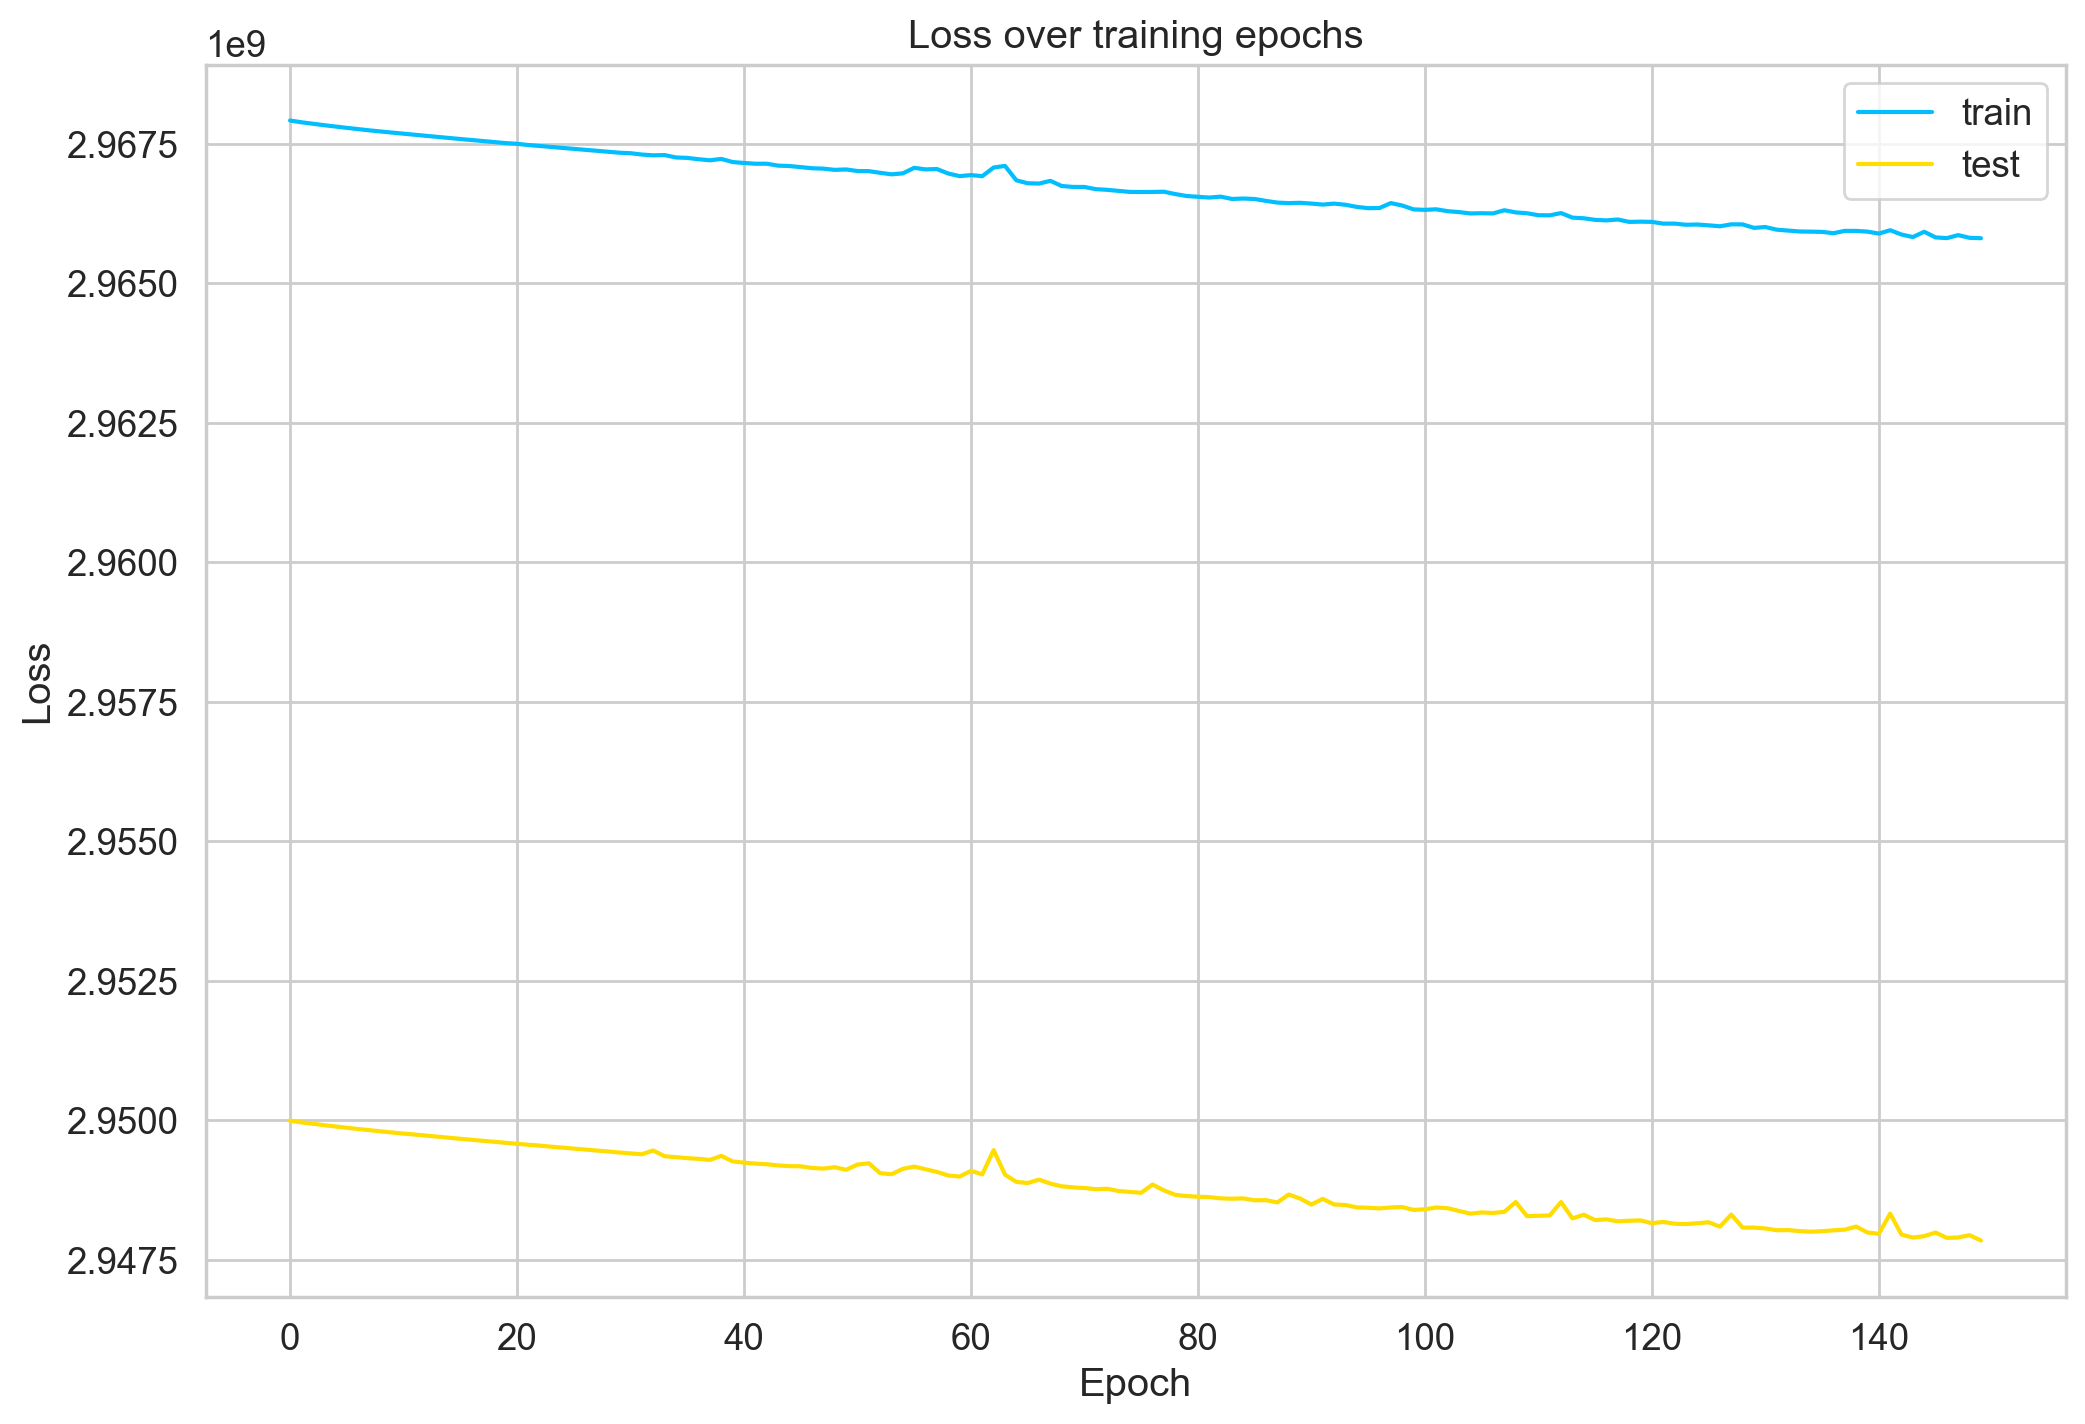

In [69]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [70]:
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

In [ ]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

In [71]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

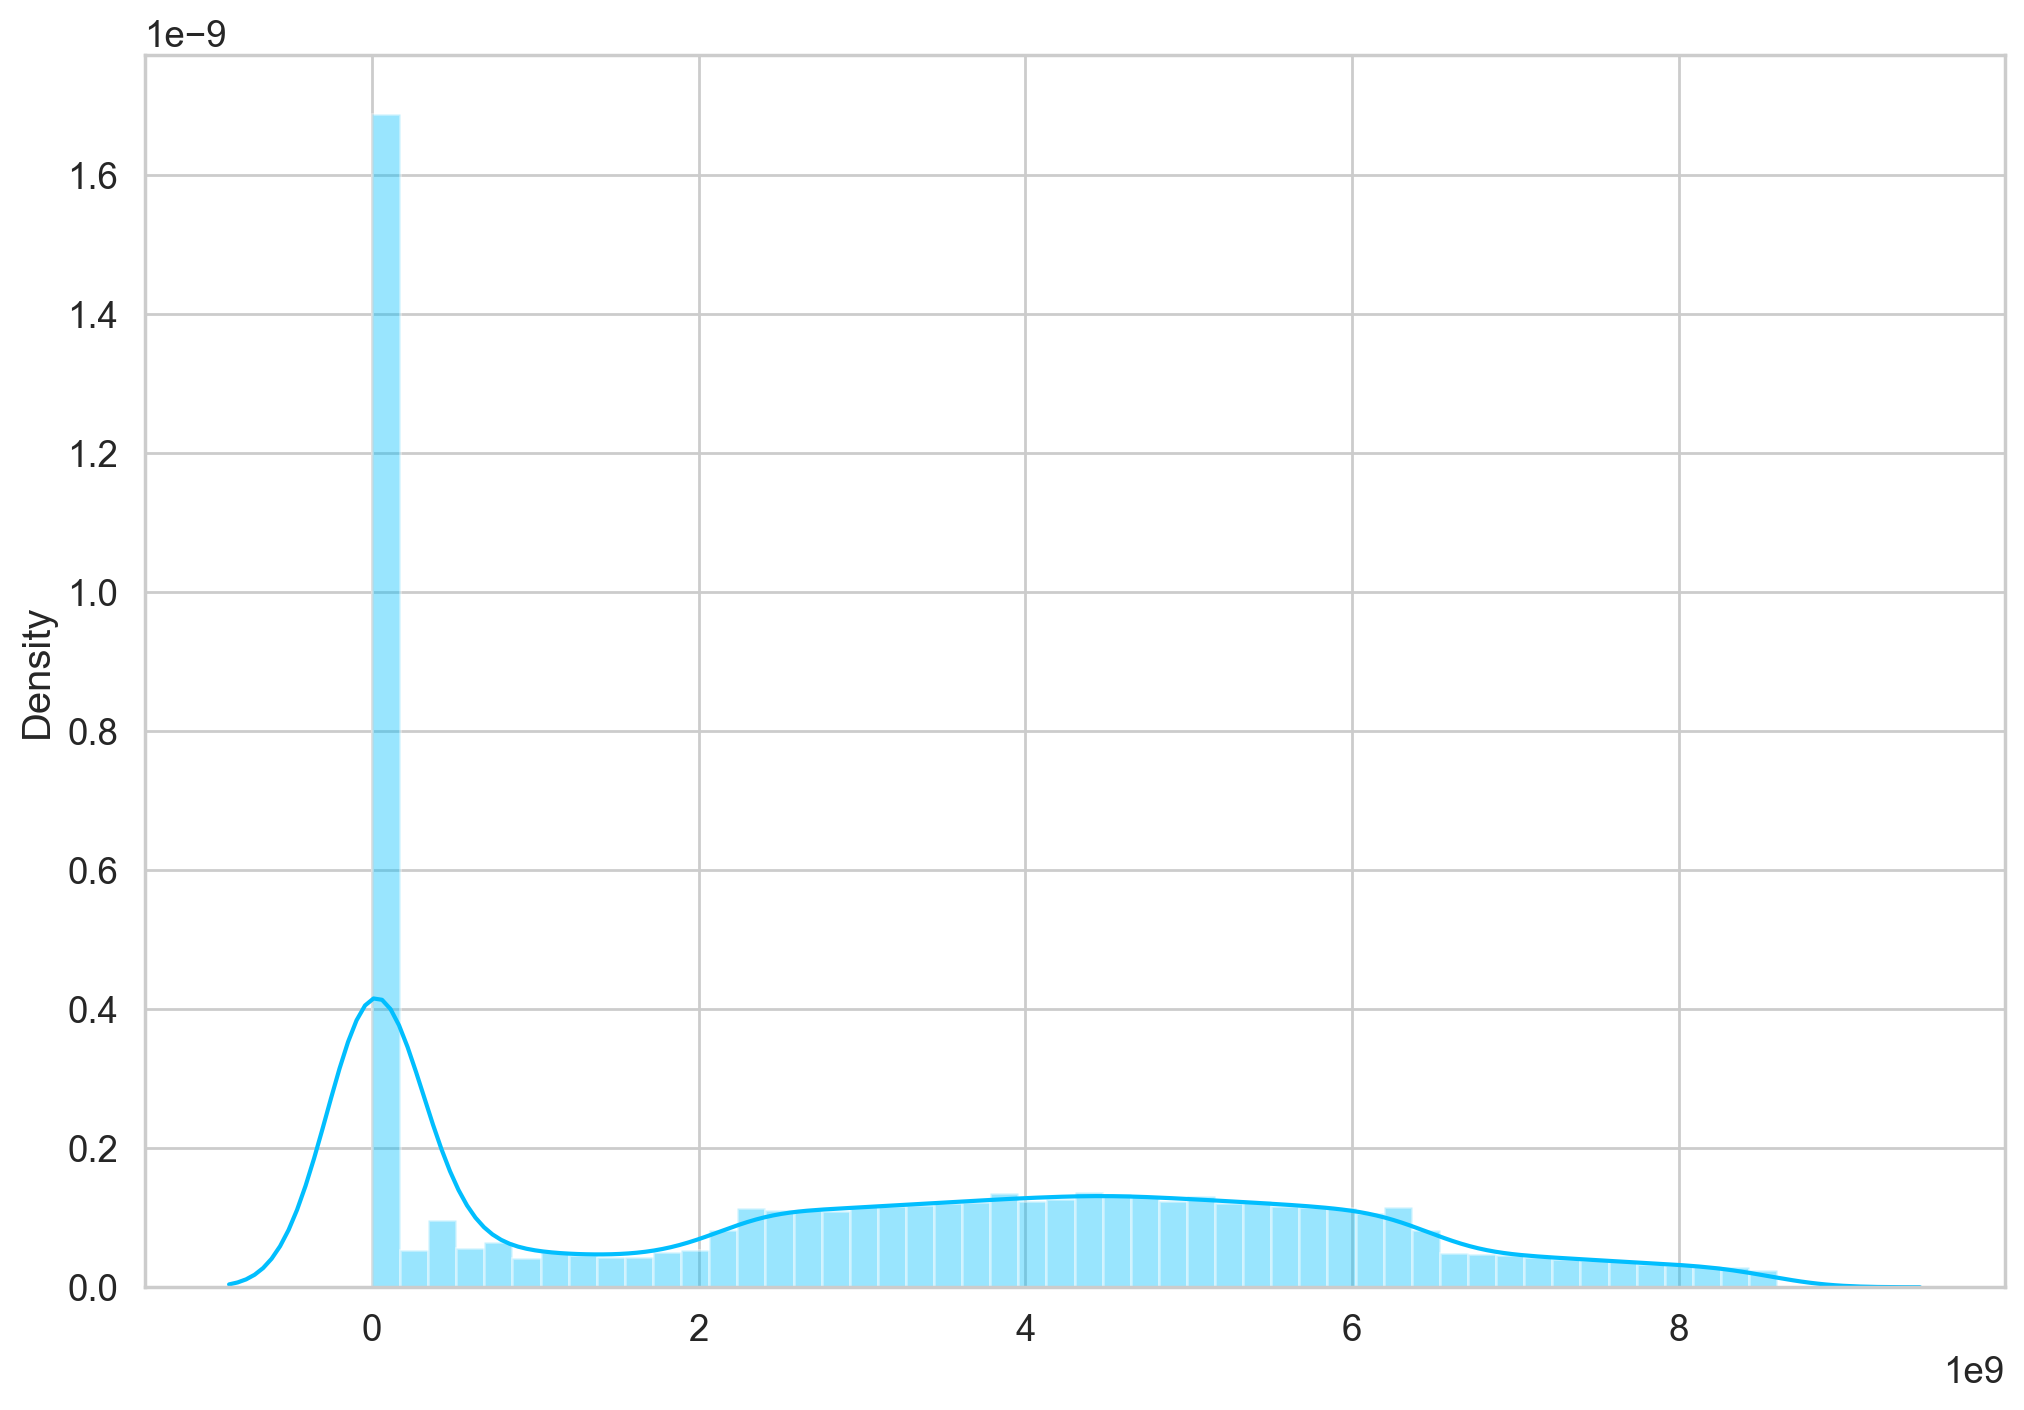

In [72]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [100]:
THRESHOLD = 6700000000

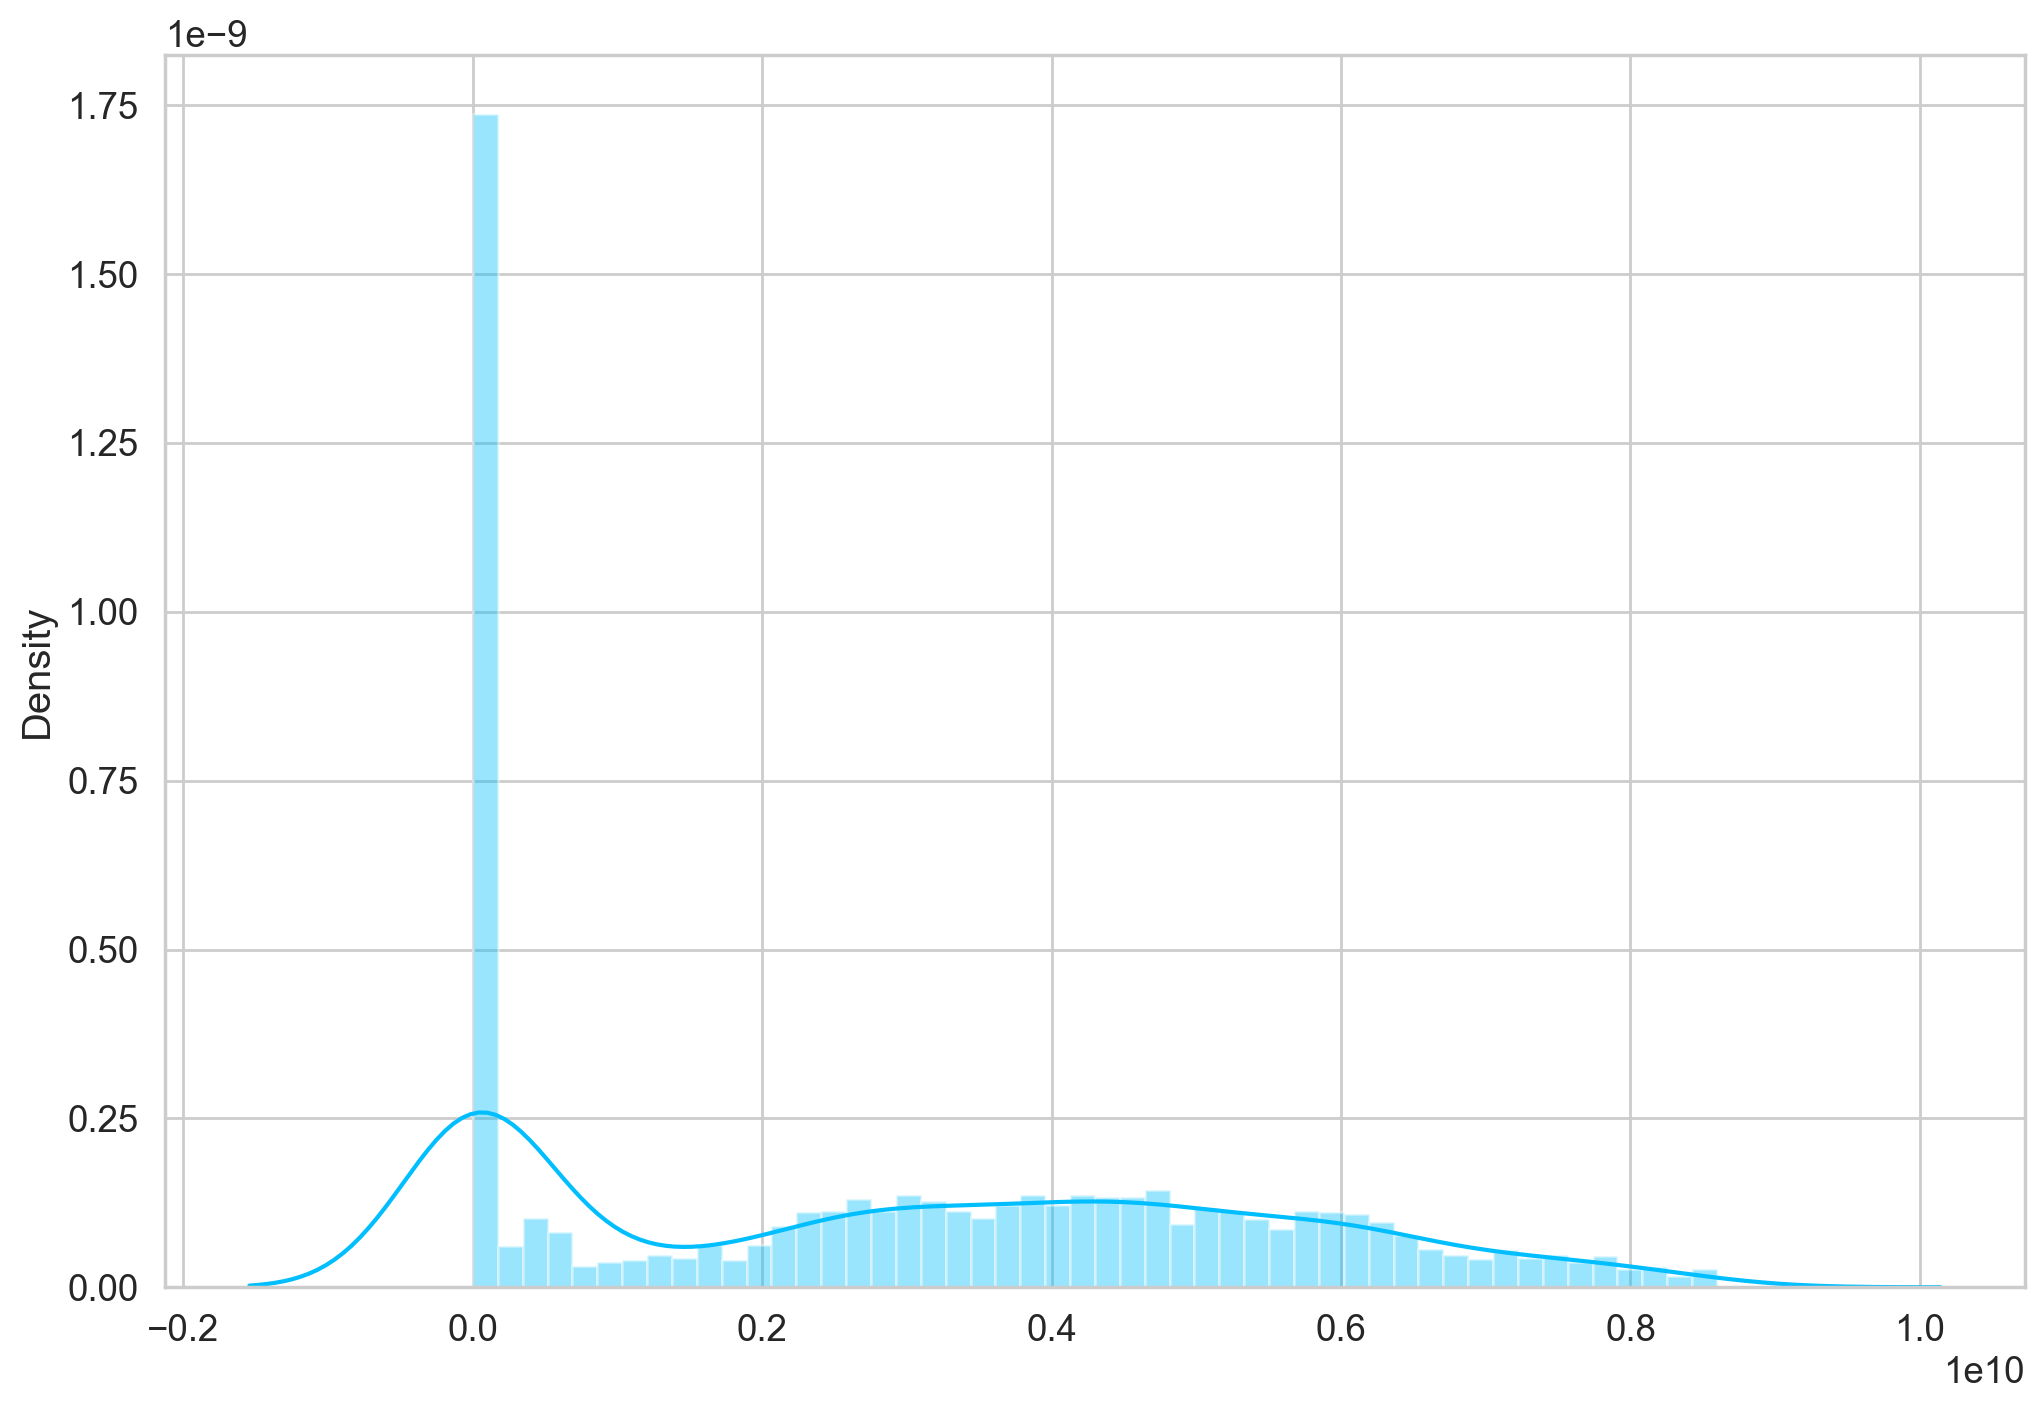

In [77]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [101]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 2569/2772


In [102]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

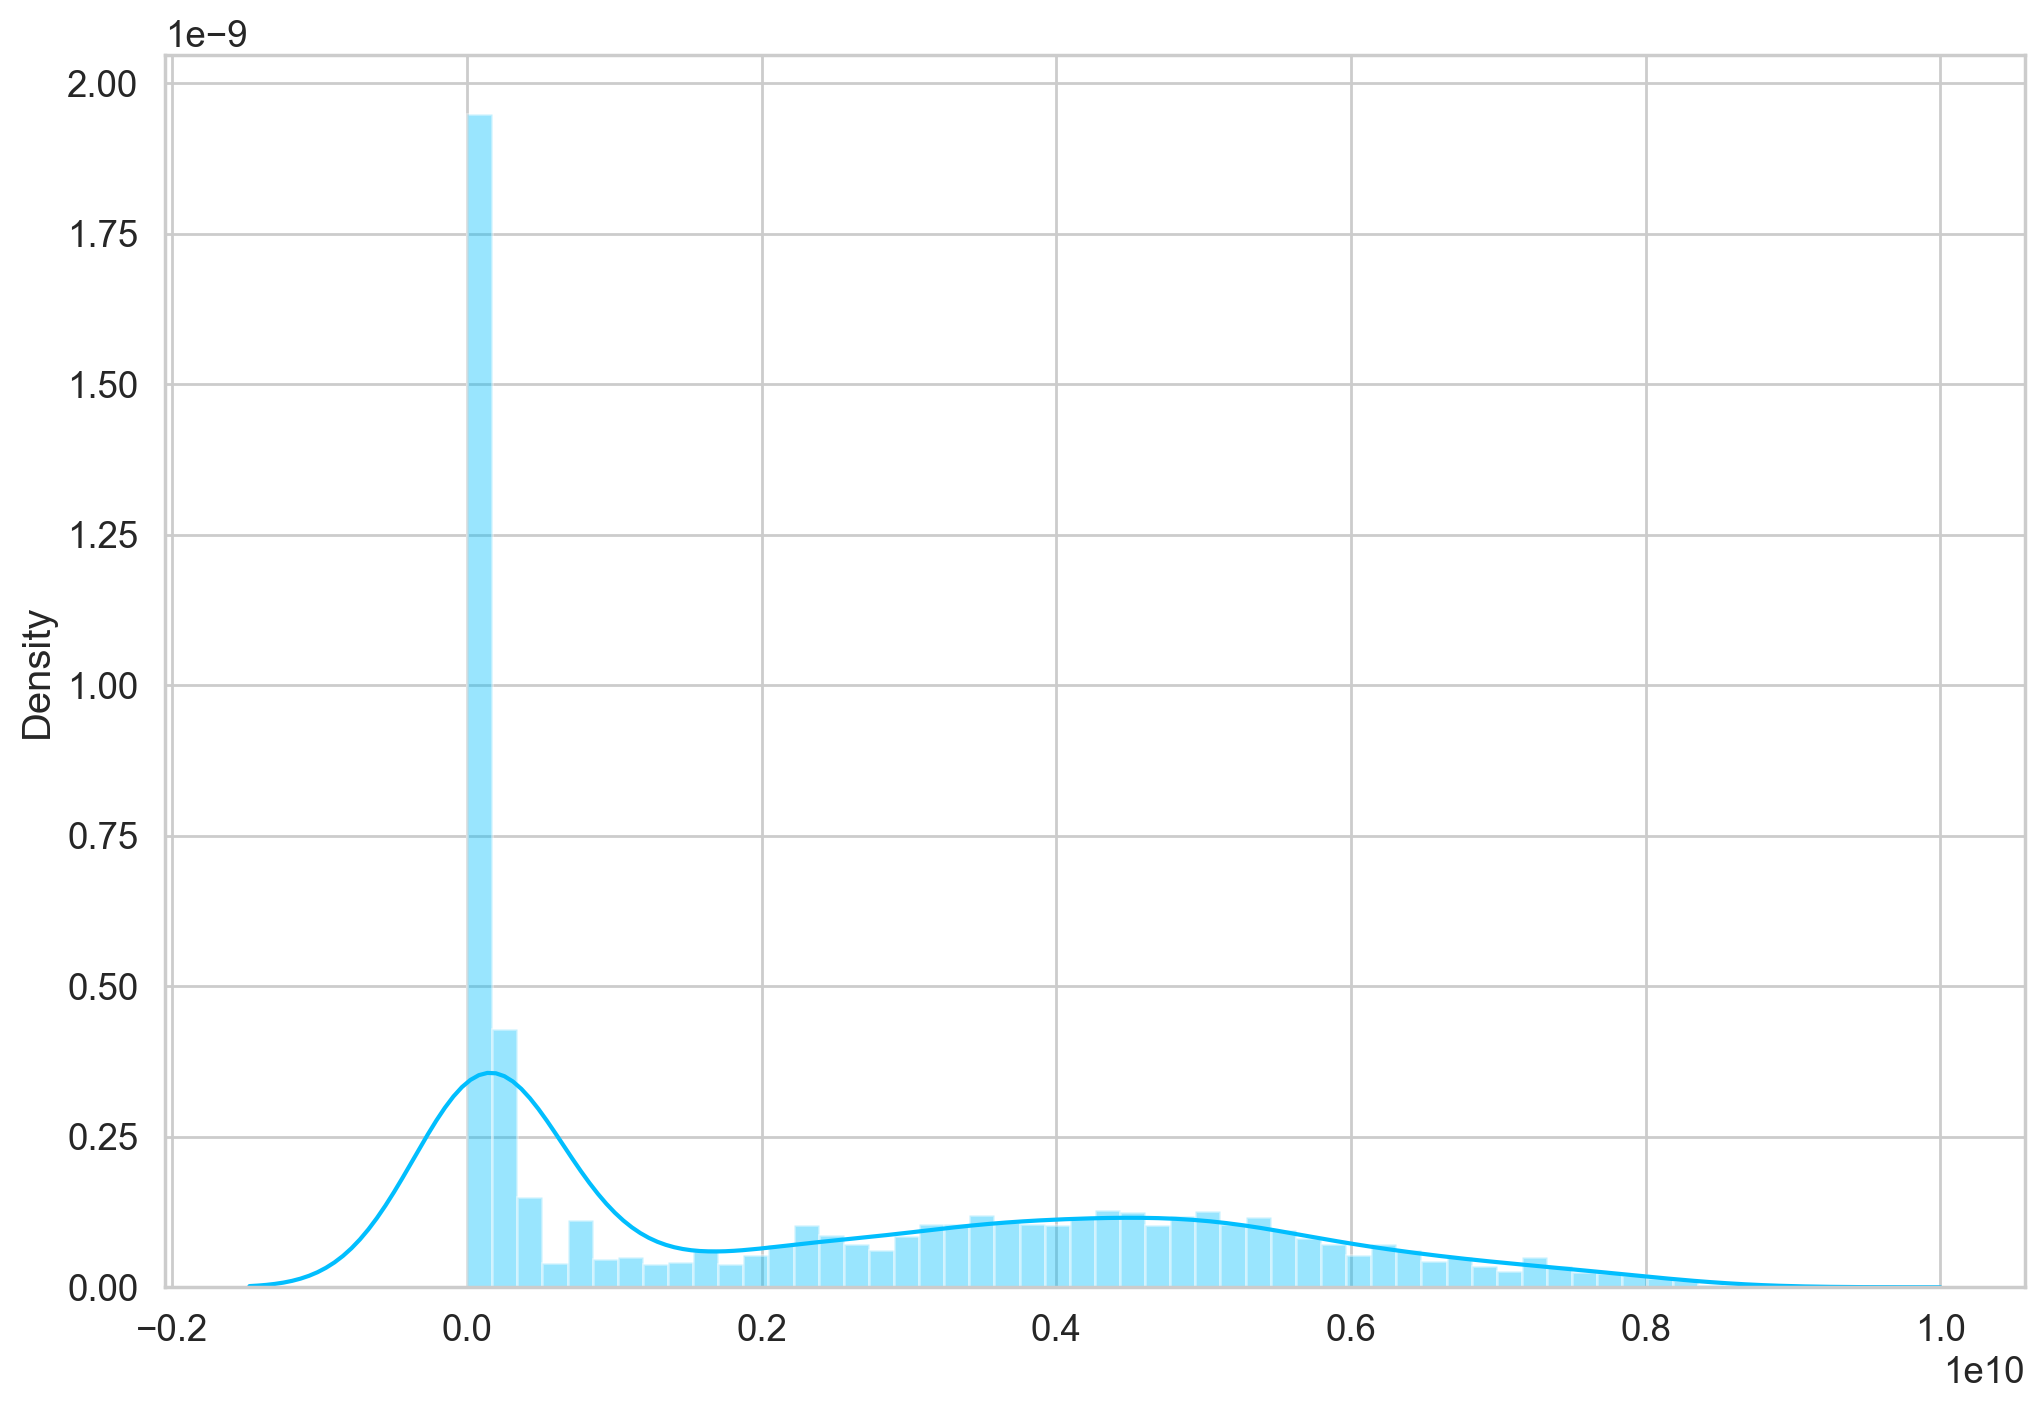

In [103]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [104]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 134/2772


In [105]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

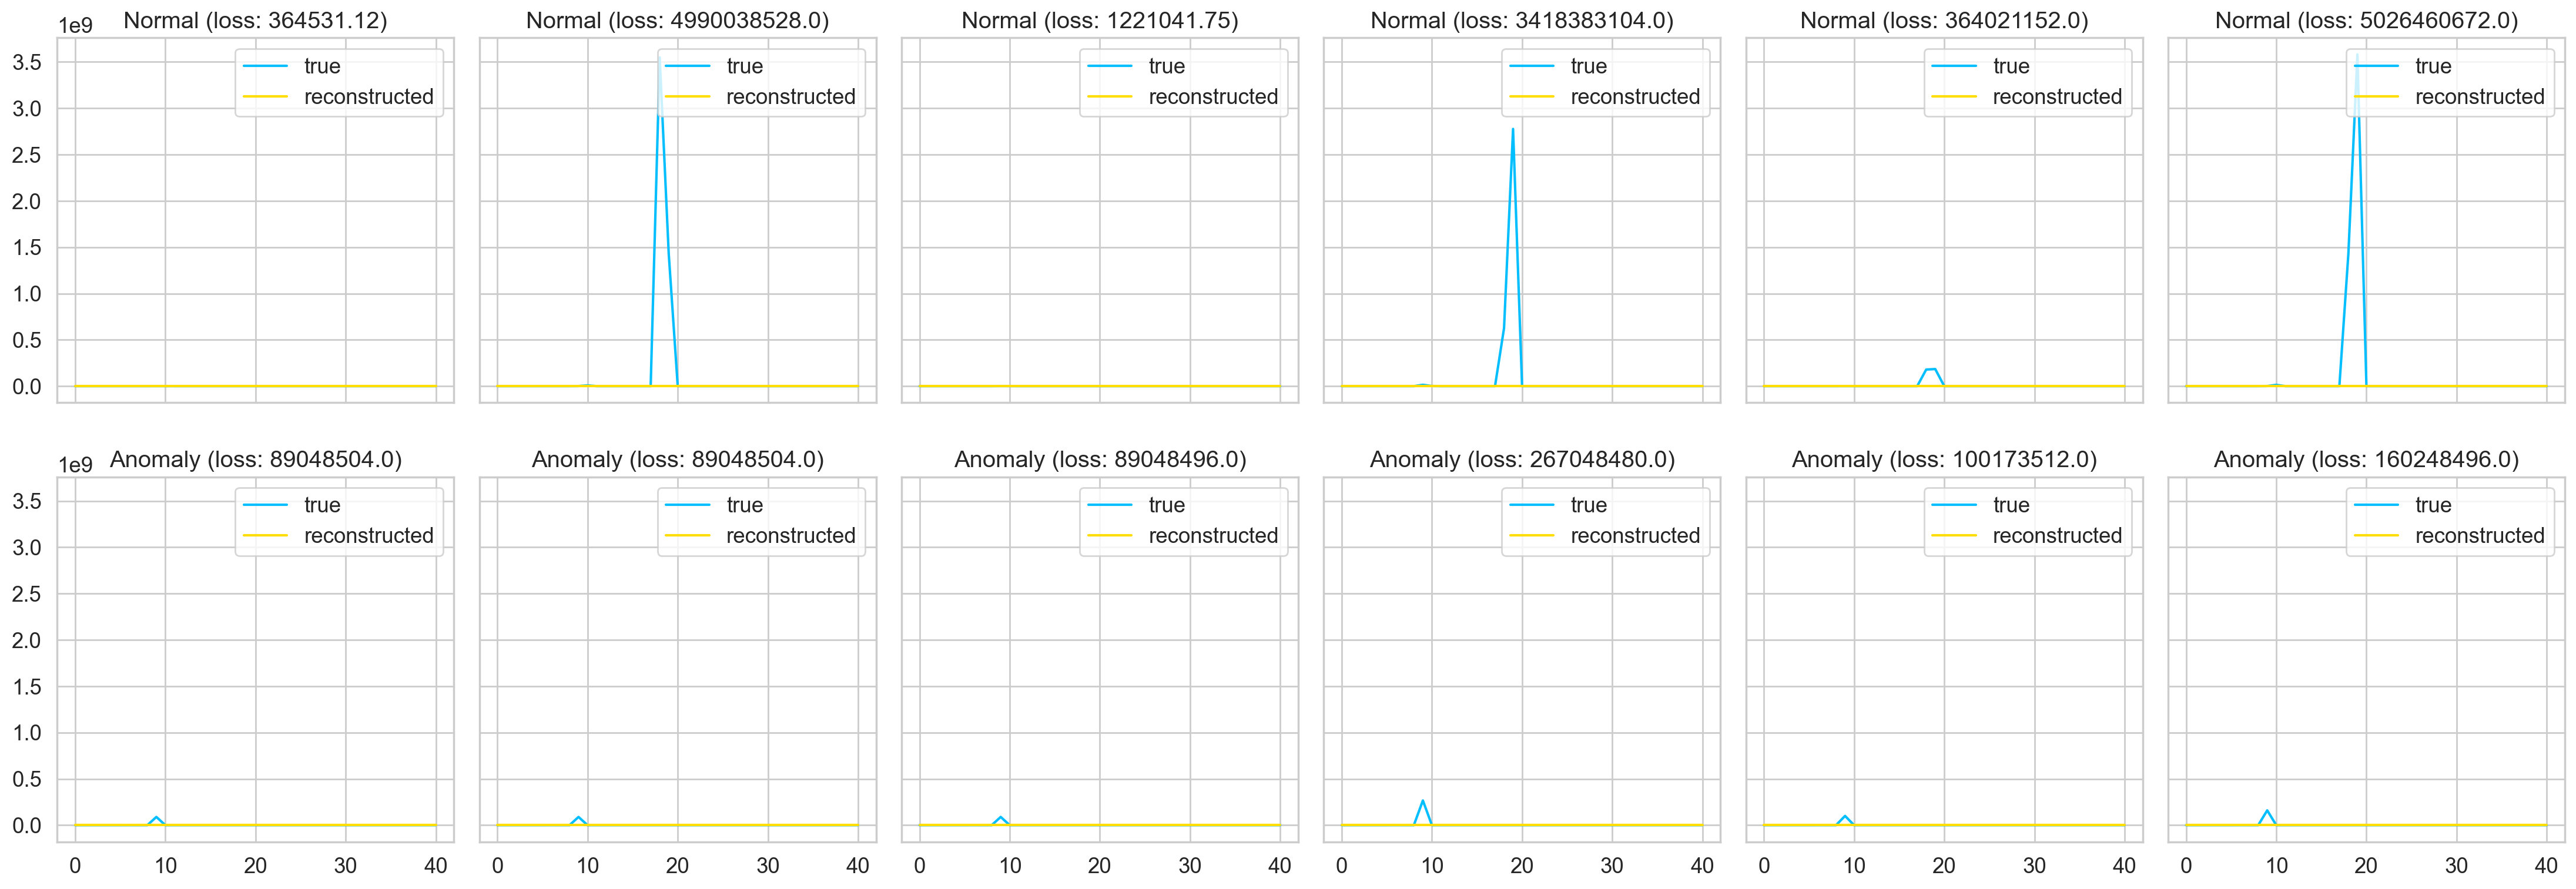

In [106]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();